In [76]:
import pandas as pd
import numpy as np
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Definition der Dataframes:

In [77]:
df_walk = pd.read_json("normal_walk.json")

df_fall = pd.read_json("fall.json")

df_testFall = pd.read_json("test_fall.json")

In [78]:
df_walk.describe()

,time,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,1.560600e+04,1.560600e+04,15605.000000,15605.000000,15605.000000,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.683269e+18,-6.919721e+02,0.051799,0.440262,0.023489,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,4.567039e+13,4.567039e+04,0.567014,1.009353,0.893979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.680417e+18,-2.852898e+06,-5.566208,-5.664675,-4.368199,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.683270e+18,1.962529e+01,-0.221366,-0.224200,-0.224045,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.683270e+18,3.925919e+01,0.022858,0.793248,0.062439,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.683270e+18,5.889272e+01,0.314255,1.077164,0.407181,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.683270e+18,7.852227e+01,4.551981,5.324697,4.855778,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
df_walk.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'version',
       'device name', 'recording time', 'platform', 'appVersion', 'device id',
       'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy',
       'pitch'],
      dtype='object')

In [80]:
#preprocessing data
df_walk['time'] = pd.to_datetime(df_walk['time'])
df_fall['time'] = pd.to_datetime(df_fall['time'])
df_testFall['time'] = pd.to_datetime(df_testFall['time'])

df_walk.head()

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,yaw,qx,qz,roll,qw,qy,pitch
0,Accelerometer,2023-04-02 06:30:19.905724160,-2.852898e+06,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AccelerometerUncalibrated,2023-05-05 06:58:38.144353792,1.635376e-02,-0.770004,-0.392059,0.095901,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AccelerometerUncalibrated,2023-05-05 06:58:38.154418944,2.641895e-02,-0.801300,-0.401917,0.068222,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AccelerometerUncalibrated,2023-05-05 06:58:38.164484096,3.648413e-02,-0.832657,-0.412109,0.057846,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AccelerometerUncalibrated,2023-05-05 06:58:38.174548992,4.654907e-02,-0.863892,-0.420822,0.063507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
df_walk = df_walk.set_index('time')
df_fall = df_fall.set_index('time')
df_testFall = df_testFall.set_index('time')

In [82]:
df_walk['sensor'].unique()

array(['Accelerometer', 'AccelerometerUncalibrated', 'Gravity',
       'Gyroscope', 'GyroscopeUncalibrated', 'Metadata', 'Orientation'],
      dtype=object)

In [83]:
df_walk_acc = df_walk[df_walk['sensor'] == 'AccelerometerUncalibrated']
df_fall_acc = df_fall[df_fall['sensor'] == 'AccelerometerUncalibrated']

df_testFall_acc = df_testFall[df_testFall['sensor'] == 'AccelerometerUncalibrated']

In [84]:
df_walk_acc = df_walk_acc[['z','x','y']]
df_fall_acc = df_fall_acc[['z','x','y']]

df_testFall_acc = df_testFall_acc[['z','x','y']]

<Axes: xlabel='time'>

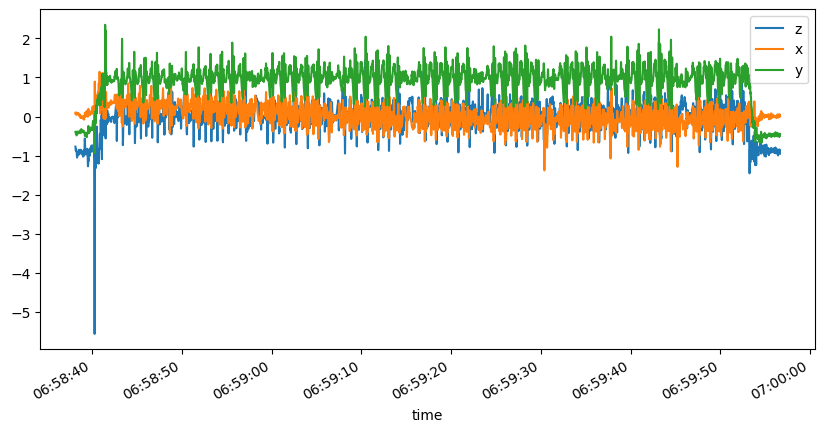

In [85]:
df_walk_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

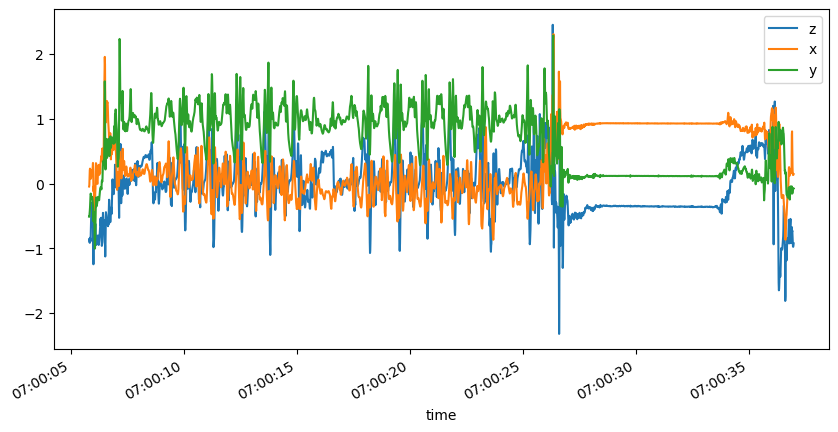

In [86]:
df_fall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

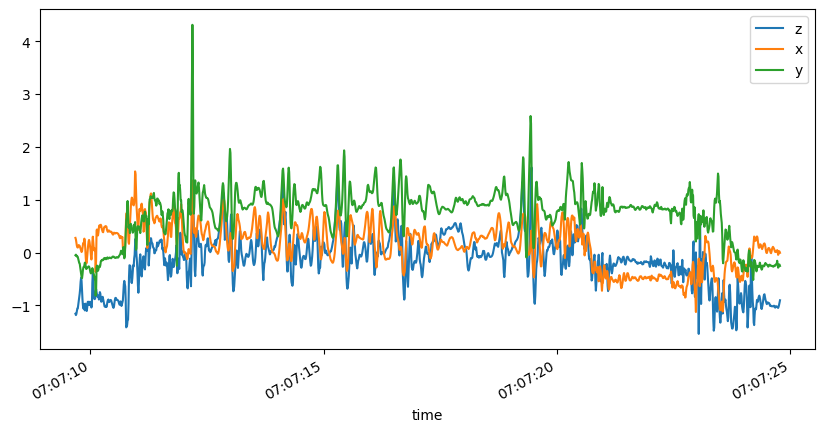

In [87]:
df_testFall_acc.plot(figsize=(10,5))

Create Training Data

In [88]:
df_walk_acc['label'] = "run"
df_fall_acc['label'] = "fall"

df_testFall_acc['label'] = "fall"

df_combined = pd.concat([df_walk_acc, df_fall_acc])

In [89]:
#Anzahl der Reihen RowCount
len(df_walk_acc)
#Label hinzufügen

display(df_combined)

,z,x,y,label
time,,,,
2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,run
2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,run
2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,run
2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,run
2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,run
...,...,...,...,...
2023-05-05 07:00:36.956347136,-0.940689,0.155502,-0.105499,fall
2023-05-05 07:00:36.966411264,-0.969910,0.134750,-0.089905,fall
2023-05-05 07:00:36.976476416,-0.975662,0.134018,-0.077606,fall


In [90]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df_combined):
    X_train, X_test = df_combined.iloc[train_index][['z','y','x']], df_combined.iloc[test_index][['z','y','x']]
    y_train, y_test = df_combined.iloc[train_index]["label"], df_combined.iloc[test_index]["label"]

    # Skalieren 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Passe Klassifikator an
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    # Evaluieren die Leistung des Klassifikators
    y_pred = clf.predict(X_test)
    #print(clf.predict(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.29334067143643366
Accuracy: 0.02531645569620253


In [91]:
df_testFall.describe()

,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,3.006000e+03,3005.000000,3005.000000,3005.000000,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,-3.789129e+03,-0.072892,0.299792,0.130411,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.040286e+05,1.034387,1.081646,0.895868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-2.853204e+06,-5.690040,-4.045646,-3.629778,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.768549e+00,-0.488541,-0.271355,-0.234379,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,7.548762e+00,-0.080276,0.493378,0.147198,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.132898e+01,0.232620,0.942459,0.496567,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.510921e+01,10.161438,4.810386,4.382080,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
ts_test = TimeSeriesSplit(n_splits=5)
for testFall_index in ts_test.split(df_testFall):
    X_test = df_testFall.iloc[testFall_index][['z','y','x']]
    y_test = df_testFall.iloc[testFall_index]["label"]

    X_test = scaler.transform(X_test)

    y_pred = clf.predict(X_test)
    #print(clf.predict(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")    


IndexError: positional indexers are out-of-bounds

Alternative Herangehensweise an die Erstellung von TestDaten:

In [ ]:
#Test via Konfusionsmatrix
y_pred = clf.predict(X_test)
accuracy = sk.metrics.confusion_matrix(y_test, y_pred)
print(accuracy)

[[  46 1771]
 [   0    0]]
